<hr style="border-width:4px; border-color:coral"/>

# Creating fractals
<hr style="border-width:4px; border-color:coral"/>

Fractals are fascinating images that can be computed using a very simple fixed-point type iteration.  And because the iterations run independently, algorithms for fractal generation parallelize very naturally.  The code below illustrate the Julia fractal.  You can read more about Julia fractals on this <a href="https://en.wikipedia.org/wiki/Julia_set">Wikipedia page</a>.

In [1]:
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from matplotlib import colors
import warnings
import multiprocessing as mp
mp.set_start_method('fork')

warnings.simplefilter("ignore")   # Suppress overflow run time warnings

The basic algorithm for computing Julia fractals is an iterative scheme, based on the following idea. 

Given a number $z_0 = x  + iy$ in the complex plane, generate iterates

\begin{equation*}
z_{k+1} = g(z_k)
\end{equation*}

where $g(z)$ is a prescribed function.  For example, the Julia fractal below uses $g(z) = z^2 + c$ where $c$ is a complex number.   

We generate these iterates for every point $z_0$ in a region $D$ in the complex plane 
(e.g. $z \in D = [-2,2]x[-2,2]$).  Then, we color each point in the region $D$ based on how quickly the sequence $\{z_{k}\}$ diverges.  To determine divergence, we measure $|z_k| = \sqrt{x^2 + y^2}$.  The sequence $z_k$ is said to have an "escape time" $K(z)$ if $|z_k| > \rho$, for all $k > K(z)$, for some $\rho \in R$ (fixed for all $z$ in $D$). If, after some predetermined $K_{max}$, we have $|z_k| < \rho, k \ge K_{max}$, we assign the escape time as $K(z_k) = \infty$.  For these values, the sequence $z_k$ does not diverge.  

Once every point $z \in D$ has an escape time $K(z)$, we can then color the domain by assigning colors to each integer value $K(z)$.  

The following code creates an $N \times N$ grid of values in the domain $[a_x,b_x\ \times [a_y,b_y]$.  The code iterates on each point in the domain to compute an escape time. 

Initially, all escape time are set to a maximum value $k_{max}$.  Escapes times are updated to values smaller than $k_{max}$ as the iterations proceed. 

In [2]:
res = 2048    # Resolution
kmax = 5000

domain_width = 4
xc = 0
yc = 0

# Choice from Mandelbrot set
c = -0.8+0.156*1j

In [3]:
def julia_set(ax,bx,ay,by, Nx, Ny, kmax,c):
    
    # Generate points in complex planes D
    xe = linspace(ax,bx, Nx+1).astype(float64)
    ye = linspace(ay,by, Ny+1).astype(float64)
    dx = (bx-ax)/N
    dy = (by-ay)/N
    xc = xe[:-1] + dx/2            
    yc = ye[:-1] + dy/2            

    # Set of initial values Z0
    zk = xc + yc[:, None] * 1j
    
    # Constant needed for Julia fractal : g(z) = z^2 + c
    C = zeros_like(zk) + c
    
    # Divergence criteria
    rho = 2.0
    
    # Vectorize the computation of g(z); Use 
    escape_time = zeros_like(zk,dtype=int) + kmax
    for n in range(kmax):
#         if N < 32:
#             print(f"Iteration {n}\n")
#             print(escape_time)
#             print("")
        escaped = less(escape_time,kmax)
        if all(escaped):
            # print(f"Breaking at n = {n}\n")
            break
        I = logical_and(greater(abs(zk), rho),logical_not(escaped))
        escape_time[I] = n
        notI = not_equal(I,True)
        zk[notI] = zk[notI]**2 + C[notI]
    Iz = equal(escape_time,kmax)
    nz = count_nonzero(Iz)  # Number of zero values who never escaped
    return zk, escape_time,nz

In [4]:
%%time

# dimensions of D
ax, bx = xc - domain_width/2, xc + domain_width/2
ay, by = yc - domain_width/2, yc + domain_width/2

N = res

Z, M, nz = julia_set(ax, bx, ay, by, N, N, kmax,c)
print(f"Number of values that did not escape {nz}")

Number of values that did not escape 0
CPU times: user 3min 13s, sys: 18 s, total: 3min 31s
Wall time: 3min 32s


## Plot results

We can show the results in the notebook using `imshow`.  But we will save them to a file using `imsave`. 

CPU times: user 307 ms, sys: 37.2 ms, total: 344 ms
Wall time: 356 ms


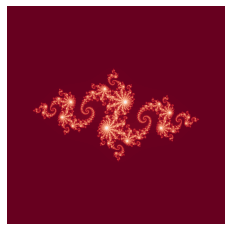

In [5]:
%%time

dpi = 16         # Figure might not show up in the notebook if dpi is too high;  but PNG file will be created (below).

# Show image in notebook
imshow(M,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
gca().axis('off')

# Save image to PNG file. Use 'imsave' so we won't get any border or padding
imsave("fractal_01.png",M,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')


<hr style="border-width:4px; border-color:coral"/>

## Accelerating the fractal

<hr style="border-width:4px; border-color:coral"/>

In [6]:
import time

# Break up the domain into quadrants.
dcount = 4
dw = 4/dcount # width of each quadrant
de = linspace(-2,2,dcount+1)

# Resolution of each quadrant
N = res//dcount

In [7]:
%time

# Keep track of number of values that "dont' escape"
nz_total = 0
nz_array = empty((dcount,dcount),dtype='int')

F = empty((res,res))
T = empty((dcount,dcount))
for i in range(dcount):
    for j in range(dcount):
        ax,bx = de[i],de[i+1]
        ay,by = de[j],de[j+1]
        
        t0 = time.time()
        Z, M, nz = julia_set(ax, bx, ay, by, N, N, kmax,c)
        t1 = time.time()
        
        etime = 1000*(t1-t0)
        T[j,i] = etime
        
        nz_total += nz
        nz_array[j,i] = nz
        
        # Swap i and j
        F[j*N:(j+1)*N,i*N:(i+1)*N] = M
        
print(f"Number of values that did not escape {nz_total}")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Number of values that did not escape 0


In [8]:
fstr = {'float' : "{:8.2f}".format, 'int' : "{:6d}".format}
set_printoptions(formatter=fstr)

print("Time")
print(T)
print("")

print("Zero count")
print(nz_array)



Time
[[   22.39    15.96    15.25    11.61]
 [ 6467.65  8308.20  7071.50 11542.39]
 [10882.70  7102.56  8794.96  5586.49]
 [   13.09    16.47    16.31    12.69]]

Zero count
[[     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]]


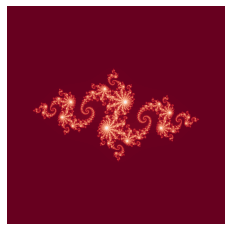

In [9]:
# Show image in notebook
imshow(F,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
gca().axis('off')

# Save image to PNG file. Use 'imsave' so we won't get any border or padding
imsave("fractal_02.png",F,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')

<hr style="border-width:4px; border-color:coral"/>

##  Parallel version : Using a queue

<hr style="border-width:4px; border-color:coral"/>

Your homework problem will be to create a parallel version of the above code using the multiprocessing module.  

* Try first using a queue and shared arrays

In [10]:
%%time 

# Create target function 
def target_func(queue):
    ax, bx, ay, by, N, kmax,c=queue.get()
    _, M, nz = julia_set(ax, bx, ay, by, N, N, kmax,c) # M is the array you care about
    nz_total.value+=nz

# Create shared arrays
fdata=empty(res*res).astype('int')
F=mp.Array('i',fdata)

nz_total=mp.Value('i',0)
# Create items for a queue
queue=mp.Queue()

for i in range(dcount):
    for j in range(dcount):
        ax,bx = de[i],de[i+1]
        ay,by = de[j],de[j+1]
        
        queue.put((ax, bx, ay, by, N, kmax,c))


# Call processors
njobs=dcount**2
jobs=[]
for i in range(njobs):
    p=mp.Process(target=target_func,args=(queue,))
    jobs.append(p)
    
for p in jobs:
    p.start()

for p in jobs:
    p.join()
    
nzt=nz_total.value
print(f"Total number of nonxeros= {nzt}")

Total number of nonxeros= 0
CPU times: user 718 ms, sys: 137 ms, total: 855 ms
Wall time: 41.2 s


In [11]:
# Process data from the shared array ...


# # Show image in notebook
# imshow(F,vmin=0,vmax=kmax/5,origin='lower',cmap=cm.RdBu)
# gca().axis('off')

# # Save image to PNG file. Use 'imsave' so we won't get any border or padding
# imsave("fractal_03.png",F,vmin=0,vmax=kmax/5,cmap=cm.RdBu,dpi=dpi,origin='lower')